In [18]:
# Pandas version 1.1.0 required

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import NearestNeighbors as KNN

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.regression.mixed_linear_model import MixedLM as LMM

from datetime import time
import os
import urllib
import shutil

#from google.colab import data_table
#data_table.enable_dataframe_formatter()

#from google.colab import files
# Load in rideshare_kaggle.csv and neighborhoods.csv here
# files.upload()



In [20]:
# Helper Functions

# Model Diagnostics
def plot_diagnostics(covariates, response, fit_model):
    coef = fit_model.params
    pred_values = fit_model.predict(covariates)
    mod_res = fit_model.resid
    
    std_res = (mod_res-np.mean(mod_res))/np.std(mod_res)
    std_pred = (pred_values-np.mean(pred_values))/np.std(pred_values)
    
    x = np.linspace(0, 10, num=10000)
    y = x*coef[1]+coef[0]
    
    # plot1 = plt.figure(1)
    # plt.plot(x, y, c="black", linewidth=3.0)
    # plt.scatter(covariates[:,1],
    #             response)
    
    plot2 = plt.figure(2)
    x_2 = np.linspace(np.min(std_pred),
                      np.max(std_pred),
                      num=10000)
    plt.scatter(std_pred,
                std_res)
    plt.plot(x_2, np.tile(np.mean(std_pred),reps=len(x)),
             c="black", linewidth=3.0)
    
    plot3 = plt.figure(3)
    plt.scatter(std_pred,
                np.log(np.abs(std_res))) # doesn't really help
    
    # regress the predicted variables against the residuals
    
    plot4 = plt.figure(4)
    plt.scatter(pred_values,
                mod_res)
    plt.show()
    
    plot5 = plt.figure(5)
    sm.qqplot(std_res, line="45")
    # light left tail; heavy right tail; very right-skew
    plt.show()
    
    plot6 = plt.figure(6)
    x_3 = np.linspace(np.min(std_pred),
                      np.max(std_pred),
                      num=40)
    plt.hist(x=std_res, bins=x_3)
    plt.show()

def plot_coef_vs_demog(coef, neighbourhoods):
    coef = coef.tolist()
    
    names = neighbourhoods["neighbourhood"]
    neighbourhoods = neighbourhoods.drop(columns="neighbourhood")
    
    for idx, var in enumerate(neighbourhoods):
        
        if idx != neighbourhoods.shape[1]:
            
            plt.figure(idx+1)
            x = coef
            
            if np.max(neighbourhoods.iloc[:,idx]) > 1000:
                y = neighbourhoods.iloc[:,idx]/1000
            else:
                y = neighbourhoods.iloc[:,idx]
            
            plt.scatter(x, y)
            plt.xlabel("coef")
            plt.ylabel(neighbourhoods.columns[idx])
            
            for j, name in enumerate(names):
                plt.annotate(name, (x[j], y[j]))
             
            plt.show()





In [21]:
# clean data
def clean_data_func():
  # We present the clean data function for reproducibility if 
  # the original dataset is downloaded. However, loading in this dataset
  # is very cumbersome.
  data = pd.read_csv("rideshare_kaggle.csv")


  # Filter out only Uber cab types
  clean_data = data.loc[(data["cab_type"]=="Uber") & (data["name"] != "Taxi")]

  # Select only the relevant geographical variables
  clean_data = clean_data[["id", "datetime", "source", "destination",
                    "name", "price", "distance", "surge_multiplier"]]
  clean_data = clean_data.rename(columns={"name": "vehicle_type"})

  # adjust for demand
  clean_data["adj_price"] = clean_data["price"]/clean_data["surge_multiplier"]

  # Parsing datetimes to times of day (morning, afternoong, evening

  clean_data["time"] = pd.to_datetime(clean_data["datetime"]).dt.time

  # from: https://stackoverflow.com/questions/39109045/numpy-where-with-multiple-conditions
  col = "time"
  time_ = clean_data["time"]

  morning_start, morning_end = time(2, 0, 0), time(11, 59, 59)
  afternoon_start, afternoon_end = time(12, 0, 0), time(17, 59, 59)
  evening_start, evening_end = time(18, 0, 0), time(1, 59, 59)

  conditions = [(time_ >= morning_start) & (time_ <= morning_end),
                (time_ >= afternoon_start) & (time_ <= afternoon_end),
                (time_ >= evening_start) | (time_ <= evening_end)]

  choices = ['morning', 'afternoon', 'evening']

  clean_data["time"] = np.select(conditions, choices, default=np.nan)

  # Set base contrasts for dummy variables
  clean_data["vehicle_type"] = np.where(clean_data["vehicle_type"]=="UberX",
                                        "Base_UberX",
                                        clean_data["vehicle_type"])

  clean_data["time"] = np.where(clean_data["time"]=="morning",
                                        "Base_morning",
                                        clean_data["time"])
  clean_data["id"] = np.arange(clean_data.shape[0])
  clean_data=clean_data.reset_index().drop(columns=["index"])
  return clean_data

#clean_data = clean_data_func()

clean_data = pd.read_csv("clean_data.csv")
clean_data

,id,datetime,source,destination,vehicle_type,price,distance,surge_multiplier,adj_price,time,count
0,009e9c53-074d-43cf-aef2-0fbc7a47ed3d,2018-11-30 22:13,North End,West End,UberXL,12.0,1.11,1,12.0,evening,1517
1,23f145da-f0c1-4d1f-a184-496bc003a7db,2018-12-13 10:50,North End,West End,Black,16.0,1.11,1,16.0,Base_morning,1846
2,357559cb-8c58-4278-a41a-e33b2e0997a3,2018-12-13 19:15,North End,West End,Base_UberX,7.5,1.11,1,7.5,evening,1524
3,50ef1165-9d23-416c-a65c-18906207b295,2018-12-16 23:55,North End,West End,WAV,7.5,1.11,1,7.5,evening,1552
4,91c4861c-1780-42b0-bca1-bbd64a422cc3,2018-12-14 0:40,North End,West End,Black SUV,26.0,1.11,1,26.0,evening,1548
...,...,...,...,...,...,...,...,...,...,...,...
330563,353e6566-b272-479e-a9c6-98bd6cb23f25,2018-12-01 23:53,West End,North End,WAV,9.5,1.00,1,9.5,evening,1581
330564,616d3611-1820-450a-9845-a9ff304a4842,2018-12-01 23:53,West End,North End,UberXL,13.0,1.00,1,13.0,evening,1555
330565,633a3fc3-1f86-4b9e-9d48-2b7132112341,2018-12-01 23:53,West End,North End,Base_UberX,9.5,1.00,1,9.5,evening,1542
330566,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,2018-12-01 23:53,West End,North End,Black SUV,27.0,1.00,1,27.0,evening,1576


In [22]:
# Neighbourhoods data
neighbourhoods = pd.read_csv("neighborhoods.csv").rename(
        columns={"name": "neighbourhood"})

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                 4.213e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:26:04   Log-Likelihood:            -1.1590e+06
No. Observations:              330568   AIC:                         2.318e+06
Df Residuals:                  330566   BIC:                         2.318e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4459      0.030    352.953      0.0

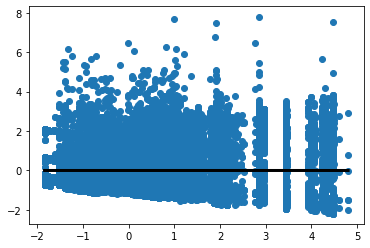

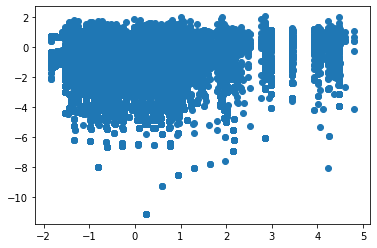

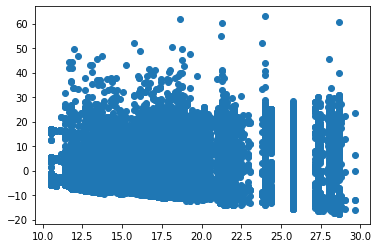

<Figure size 432x288 with 0 Axes>

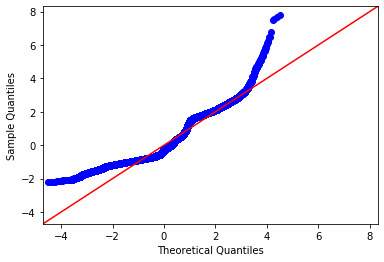

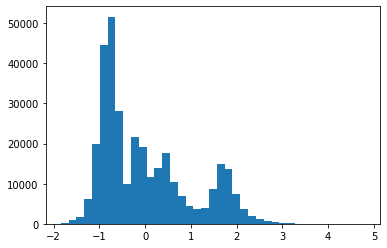

In [23]:
# fit model online
response = clean_data["adj_price"].to_numpy()
covariates = clean_data["distance"].to_numpy()

clean_response = response[~np.isnan(response)].reshape((-1,1))
clean_covariates = covariates[~np.isnan(response)].reshape((-1,1))

clean_covariates = sm.add_constant(clean_covariates, prepend=True)

# Model fit
md_online = sm.OLS(clean_response, clean_covariates).fit()

print(md_online.summary())

plot_diagnostics(clean_covariates, clean_response, md_online)

In [24]:
# Fit Larger OLS w interactions
design_matrix=pd.concat(
            [pd.get_dummies(clean_data[["vehicle_type","time"]], drop_first=True),
             pd.get_dummies(clean_data["source"])], axis=1)
        
poly = PolynomialFeatures(interaction_only=True)
interaction_matrix = poly.fit_transform(design_matrix)
interaction_cols = poly.get_feature_names(design_matrix.columns)
    
interaction_matrix = pd.DataFrame(interaction_matrix)
interaction_matrix.columns = interaction_cols
    
interaction_matrix=pd.concat([interaction_matrix, clean_data["distance"]],
                                     axis=1)
        #interaction_matrix=sm.add_constant(design_matrix, prepend=True)
        
endog, lamb = boxcox(response.astype("float64"))
exog = interaction_matrix.astype("float64")

mdf_large_ols_int = sm.OLS(endog, exog).fit()
print(mdf_large_ols_int.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 3.428e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:26:18   Log-Likelihood:             5.1693e+05
No. Observations:              330568   AIC:                        -1.034e+06
Df Residuals:                  330461   BIC:                        -1.033e+06
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

C:\Users\Harold\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Harold\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Harold\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Harold\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 1.776e+05
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:26:19   Log-Likelihood:             5.1342e+05
No. Observations:              330568   AIC:                        -1.027e+06
Df Residuals:                  330547   BIC:                        -1.027e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

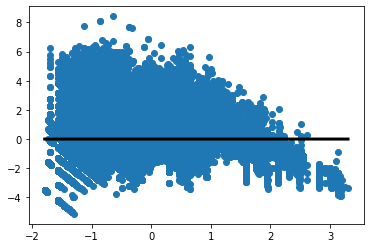

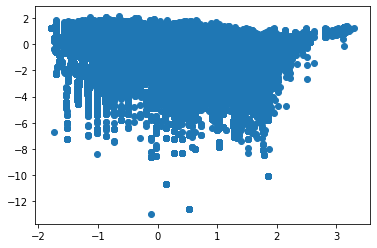

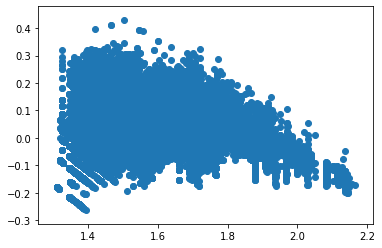

<Figure size 432x288 with 0 Axes>

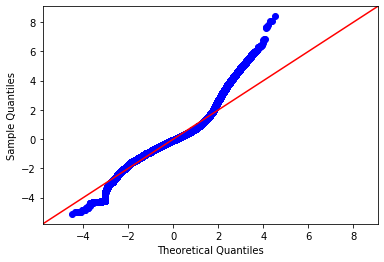

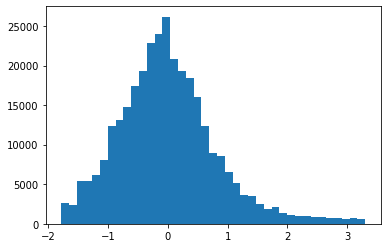

In [25]:
# OLS (Larger)

predictors = clean_data[["distance", "time", "vehicle_type", "source"]]
response = clean_data["adj_price"]

design_matrix=pd.concat(
            [pd.get_dummies(clean_data[["vehicle_type","time"]], drop_first=True),
             pd.get_dummies(clean_data["source"]), predictors["distance"]],
             axis=1)
    
design_matrix = sm.add_constant(design_matrix, prepend=True)
        
endog, lamb = boxcox(response.astype("float64"))
exog = design_matrix.astype("float64")
 

mdf_ols_larger = sm.OLS(endog, exog).fit()
print(mdf_ols_larger.summary())
        
print(lamb)
        
plot_diagnostics(design_matrix, response, mdf_ols_larger)
        

In [26]:
# fit LMM
def fit_LMM(data):
  predictors = data[["distance", "source", "vehicle_type"]]
  #data = pd.concat([predictors, response], axis=1)
  #data["groups"]=data["vehicle_type"]
          
  data["bc_adj_price"], lamb = boxcox(data["adj_price"].astype("float64"))
          
  mdf_lmm = smf.mixedlm("bc_adj_price ~ distance + C(source)",
                    data=data, 
                    groups="vehicle_type").fit()
  # mdf = smf.mixedlm("adj_price ~ distance * C(source)",
  #                  data=data, groups="vehicle_type").fit()
  print(mdf_lmm.summary())
  return mdf_lmm, lamb

mdf_lmm, lamb = fit_LMM(data=clean_data)

                     Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        bc_adj_price
No. Observations:         330568         Method:                    REML        
No. Groups:               6              Scale:                     0.0026      
Min. group size:          55091          Log-Likelihood:            513362.5462 
Max. group size:          55096          Converged:                 Yes         
Mean group size:          55094.7                                               
--------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                             1.490    0.049  30.210 0.000  1.393  1.586
C(source)[T.Beacon Hill]              0.003    0.000   5.803 0.000  0.002  0.003
C(source)[T.Boston University]       -0.008    0.0

In [27]:
def fit_online_OLS(data): 
    mdf_ols_online = smf.ols("adj_price ~ distance", data=data).fit()
    print(mdf_ols_online.summary())

    return mdf_ols_online, None

mdf_ols, _ = fit_online_OLS(clean_data)


                            OLS Regression Results                            
Dep. Variable:              adj_price   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                 4.213e+04
Date:                Wed, 15 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:26:33   Log-Likelihood:            -1.1590e+06
No. Observations:              330568   AIC:                         2.318e+06
Df Residuals:                  330566   BIC:                         2.318e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4459      0.030    352.953      0.0

In [29]:

# Generate data splits
#
#clean_data["bc_adj_price"], lamb = boxcox(data["adj_price"].astype("float64"))
#clean_data = clean_data_func()


clean_data = pd.read_csv("clean_data.csv")

clean_data["id"] = np.arange(clean_data.shape[0])

np.random.seed(seed=0)

sample=clean_data.groupby(by=["vehicle_type", "source"]).sample(frac=0.75)\
[["id", "source", "distance", "vehicle_type", "adj_price"]]

train_id = sample["id"].to_numpy()
test_id = ~np.isin(np.arange(clean_data.shape[0]),train_id)

features = clean_data[sample.columns]

train_features = features.iloc[train_id,:]
test_features = features.iloc[test_id,:]

test_features

train_labels = features.iloc[train_id]["adj_price"].to_numpy()
test_labels = features.iloc[test_id]["adj_price"].to_numpy()

trained_LMM, train_lamb_LMM = fit_LMM(data=train_features)
trained_OLS_orig, _ = fit_online_OLS(data=train_features)

def eval_rmse_by_nb(mdf, lamb):

  coef=mdf.params
  if lamb is not None:
    train_pred=inv_boxcox(mdf.fittedvalues, lamb)
    test_pred=inv_boxcox(mdf.predict(test_features), lamb)
  else:
    train_pred = mdf.fittedvalues
    test_pred = mdf.predict(test_features)

  comp_preds = pd.DataFrame({"pred": test_pred,
                            "veh": test_features["vehicle_type"],
                            "nb": test_features["source"],
                            "true": test_features["adj_price"]})

  comp_preds["rmse"]=np.sqrt(np.subtract(comp_preds["pred"], comp_preds["true"])**2)

  return comp_preds

  #return rmse_by_nb.reset_index(), test_pred

# Now get the rmse by neighbourhood
rmse_by_nb_lmm = eval_rmse_by_nb(trained_LMM, train_lamb_LMM)
rmse_by_nb_ols = eval_rmse_by_nb(trained_OLS_orig, None)

rmse_by_nb_ols
rmse_by_nb_lmm

ols_results=rmse_by_nb_ols.groupby(by=["veh", "nb"]).mean().reset_index()
ols_results=pd.merge(left=ols_results, right=neighbourhoods,
                     left_on = "nb", right_on = "neighbourhood",
                     how="left").dropna()
ols_results.sort_values(by=["veh", "avg_house_income"])

ols_results.sort_values(by=["veh", "avg_house_income"]).to_csv("ols_results.csv")

# Run this to see that at lower avg_house_incomes, we see greater RMSE!

lmm_results=rmse_by_nb_lmm.groupby(by=["veh", "nb"]).mean().reset_index()
lmm_results=pd.merge(left=lmm_results, right=neighbourhoods,
                     left_on = "nb", right_on = "neighbourhood",
                     how="left").dropna()
lmm_results.sort_values(by=["veh", "avg_house_income"])

lmm_results.sort_values(by=["veh", "avg_house_income"]).to_csv("lmm_results.csv")


AttributeError: 'DataFrameGroupBy' object has no attribute 'sample'

In [ ]:
# Results



# Model summaries
fixed_eff=pd.DataFrame(mdf_lmm.params.rename(index="value"))
rand_eff=pd.DataFrame(mdf_lmm.random_effects).T.rename(columns={"vehicle_type": "value"})

pd.concat([fixed_eff, rand_eff]).to_csv("lmm_effects.csv")


mdf_ols.params # Not very useful
pd.DataFrame(mdf_ols.params).to_csv("ols_effects.csv")

# Price discrimination - model mean prediction and rmse

train_lamb_LMM
lmm_results.sort_values(by=["veh", "avg_house_income"]).to_csv("lmm_results.csv")
ols_results.sort_values(by=["veh", "avg_house_income"]).to_csv("ols_results.csv")